# Realizamos nuestro forecast
_Importación de librerias_

In [78]:
import pandas as pd
from darts import TimeSeries
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.metrics import mape, smape

import tfm_helpers as tfm

pd.set_option("display.max_columns", None)

In [79]:
# Read a pandas DataFrame
df = pd.read_parquet(tfm.getPathToProcessedSnapshotResumenOcupacion("parquet"))

df.head()


Cantidad habitaciones  Habitaciones Hotel
Hotel Fecha foto Fecha prevision                                           
02    2012-06-10 2013-09-19                           1               297.0
                 2013-09-20                           1               297.0
                 2013-09-21                           1               297.0
                 2013-09-22                           1               297.0
                 2013-09-23                           1               297.0

In [80]:
df["% Ocupacion"] = df["Cantidad habitaciones"] / df["Habitaciones Hotel"]

hotel_02 = df.loc["02"]
hotel_02.head()

Cantidad habitaciones  Habitaciones Hotel  \
Fecha foto Fecha prevision                                              
2012-06-10 2013-09-19                           1               297.0   
           2013-09-20                           1               297.0   
           2013-09-21                           1               297.0   
           2013-09-22                           1               297.0   
           2013-09-23                           1               297.0   

                            % Ocupacion  
Fecha foto Fecha prevision               
2012-06-10 2013-09-19          0.003367  
           2013-09-20          0.003367  
           2013-09-21          0.003367  
           2013-09-22          0.003367  
           2013-09-23          0.003367

In [81]:

hotel_02_2019 = df.loc[("02",slice(None), "2019-07-01")].reset_index()
hotel_02_2018 = df.loc[("02",slice(None), "2018-07-01")].reset_index()
hotel_02_2017 = df.loc[("02",slice(None), "2017-07-01")].reset_index()
hotel_02_2016 = df.loc[("02",slice(None), "2016-07-01")].reset_index()
hotel_02_2015 = df.loc[("02",slice(None), "2015-07-01")].reset_index()
hotel_02_2014 = df.loc[("02",slice(None), "2014-07-01")].reset_index()
hotel_02_2013 = df.loc[("02",slice(None), "2013-07-01")].reset_index()


In [82]:

hotel_02_2014.head()

,Hotel,Fecha foto,Fecha prevision,Cantidad habitaciones,Habitaciones Hotel,% Ocupacion
0,02,2013-10-03,2014-07-01,1,297.0,0.003367
1,02,2013-10-04,2014-07-01,1,297.0,0.003367
2,02,2013-10-05,2014-07-01,1,297.0,0.003367
3,02,2013-10-06,2014-07-01,1,297.0,0.003367
4,02,2013-10-07,2014-07-01,1,297.0,0.003367


In [83]:

# Create a TimeSeries, specifying the time and value columns
series_hotel_02_2019 = TimeSeries.from_dataframe(hotel_02_2019, "Fecha foto", "% Ocupacion")
series_hotel_02_2018 = TimeSeries.from_dataframe(hotel_02_2018, "Fecha foto", "% Ocupacion")
series_hotel_02_2017 = TimeSeries.from_dataframe(hotel_02_2017, "Fecha foto", "% Ocupacion")
series_hotel_02_2016 = TimeSeries.from_dataframe(hotel_02_2016, "Fecha foto", "% Ocupacion")
series_hotel_02_2015 = TimeSeries.from_dataframe(hotel_02_2015, "Fecha foto", "% Ocupacion")
series_hotel_02_2014 = TimeSeries.from_dataframe(hotel_02_2014, "Fecha foto", "% Ocupacion")
series_hotel_02_2013 = TimeSeries.from_dataframe(hotel_02_2013, "Fecha foto", "% Ocupacion")

# Set aside the last 36 months as a validation series
train_hotel_02_2019, val_hotel_02_2019 = series_hotel_02_2019[:-36], series_hotel_02_2019[-36:]
train_hotel_02_2018, val_hotel_02_2018 = series_hotel_02_2018[:-36], series_hotel_02_2018[-36:]
train_hotel_02_2017, val_hotel_02_2017 = series_hotel_02_2017[:-36], series_hotel_02_2017[-36:]
train_hotel_02_2016, val_hotel_02_2016 = series_hotel_02_2016[:-36], series_hotel_02_2016[-36:]
train_hotel_02_2015, val_hotel_02_2015 = series_hotel_02_2015[:-36], series_hotel_02_2015[-36:]
train_hotel_02_2014, val_hotel_02_2014 = series_hotel_02_2014[:-36], series_hotel_02_2014[-36:]
train_hotel_02_2013, val_hotel_02_2013 = series_hotel_02_2013[:-36], series_hotel_02_2013[-36:]

In [86]:
model_hotel_02 = NBEATSModel(input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=0)

In [87]:
# model_hotel_02.fit([train_hotel_02_2019, train_hotel_02_2018, train_hotel_02_2017, train_hotel_02_2016, train_hotel_02_2015, train_hotel_02_2014, train_hotel_02_2013], verbose=True)
model_hotel_02.fit([train_hotel_02_2019, train_hotel_02_2018], verbose=True)

[2022-01-22 21:10:22,547] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 558 samples.
[2022-01-22 21:10:22,547] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 558 samples.
[2022-01-22 21:10:23,262] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-01-22 21:10:23,262] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/100 [00:00<?, ?it/s]

MAPE = 8.28%


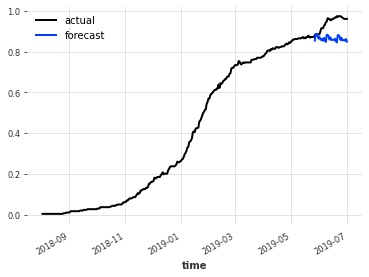

In [88]:
pred = model_hotel_02.predict(n=36, series=train_hotel_02_2019)

series_hotel_02_2019 .plot(label='actual')
pred.plot(label='forecast')
plt.legend();
print('MAPE = {:.2f}%'.format(mape(series_hotel_02_2019, pred)))

In [89]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train_hotel_02_2019)
prediction = model.predict(len(val_hotel_02_2019), num_samples=1000)

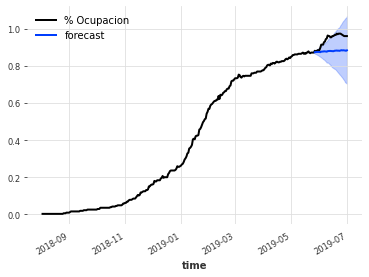

In [90]:
import matplotlib.pyplot as plt

series_hotel_02_2019.plot()
prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend();
print('MAPE = {:.2f}%'.format(mape(series_hotel_02_2019, pred)))